<a href="https://colab.research.google.com/github/tetianasokolova/computer-vision-project/blob/main/CVDL_Project_Task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Task 1 of Tetiana Sokolova

## Instructions
**Підготовка до виконання проекту**
## 1. Налаштування середовища:

Google Colab:

1. Відкрийте Google Colab: Перейдіть на сторінку Google Colab.
2. Створіть новий ноутбук: Оберіть "File" → "New Notebook".
3. Переконайтеся, що ви використовуєте GPU: "Runtime" → "Change runtime
type", оберіть "GPU".


## 2. Пошук та вибір датасету на Kaggle:
1. Перейдіть Kaggle, створіть або увійдіть у свій обліковий запис.
2. Оберіть датасет:
- **Intel Image Classification**: Знайдіть і завантажте датасет для класифікації
місцевостей.
https://drive.google.com/file/d/1xEwPYoiY8wsyF33LCTrRhDywbfC82fg/
view?usp=sharing
- **Animals-10**: Знайдіть і завантажте датасет із 10 класами тварин.
https://drive.google.com/file/d/14K-mXAqqk8cNdTmZHEmMVf7y4wtuSxJ/
view?usp=sharing
- Або ви можете скористатись датасетом Dog emo:
https://drive.google.com/drive/folders/165dCp7s0nOTxIYYCT0MDURwHI3b8foJl?usp=sha
ring
3. Після вибору датасету скачайте файл zip або tar, підготуйте файли для завантаження в обраному середовищі.

## 3. Завантаження датасету і ознайомлення зі структурою
1. Ознайомлення з датасетом:
- &#9989; Завантажте датасет у середовище використовуючи кнопку “Upload” або
підключіть свій акаунт Google Drive:
from google.colab import drive
drive.mount('/content/drive')

**Огляньте структуру датасету:**
-  &#9989; визначте кількість класів (навчальна множина / тестова);
- &#9989; виділіть валідаційну множину;
- &#9989; структуру каталогів (папок);
- &#9989; ознайомтеся з форматом файлів; **JPEG File**
- &#9989; виконайте перетворення в тензори;
- &#9989; денормалізація (при необхідності);
- &#9989; створіть DataLoader для навчального та тестового наборів даних, щоб спростити процес завантаження даних за батчами;
- &#9989; реалізуйте аугментацію даних для підвищення загальної якості моделі;
- &#9989; проаналізуйте якість даних, перевірте на наявність зашумлень або незбалансованих класів;
- &#9989; візуалізуйте по декілька прикладів з різних класів;
- &#9989; створіть графік (наприклад, гістограму), який відображає кількість зображень в кожному класі. Ви можете використовувати бібліотеку matplotlib/seaborn для візуалізації.

Додайте файл README.md, в якому коротко описано проект та інструкцію по
налаштуванню середовища до свого github.

In [ ]:
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.utils import make_grid
from collections import defaultdict

## Load the dataset Animals-10
Connect to Google Drive account.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Unzip in Colab's temporary storage
zip_path = "/content/drive/MyDrive/NaUKMAProgramming/DeepLearning/Data/Animals-10.zip"
data_path = "/content/raw-img"  # Extract in Colab's temporary storage

if not os.path.exists(data_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("/content/")  # Extract directly to /content/

In [ ]:
# Load the data
data = datasets.ImageFolder(root=data_path)

There are 26,179 images in Animal-10 dataset.

In [ ]:
len(data)

26179

Check classes of the data. We see that there are 10 classes of animals.

In [ ]:
# Check class-to-index mapping
data.classes

['cane',
 'cavallo',
 'elefante',
 'farfalla',
 'gallina',
 'gatto',
 'mucca',
 'pecora',
 'ragno',
 'scoiattolo']

Translate classes names from Italian to English using dictionary from Python file in the data archiv.

In [ ]:
translate = {"cane": "dog",
             "cavallo": "horse",
             "elefante": "elephant",
             "farfalla": "butterfly",
             "gallina": "chicken",
             "gatto": "cat",
             "mucca": "cow",
             "pecora": "sheep",
             "ragno": "spider",
             "scoiattolo": "squirrel"}

In [ ]:
data.classes = [translate.get(name, name) for name in data.classes]
data.class_to_idx = {name: idx for idx, name in enumerate(data.classes)}

In [ ]:
data.classes

['dog',
 'horse',
 'elephant',
 'butterfly',
 'chicken',
 'cat',
 'cow',
 'sheep',
 'spider',
 'squirrel']

In [ ]:
 data.class_to_idx

{'dog': 0,
 'horse': 1,
 'elephant': 2,
 'butterfly': 3,
 'chicken': 4,
 'cat': 5,
 'cow': 6,
 'sheep': 7,
 'spider': 8,
 'squirrel': 9}

## Transform data
Set up data transformations for train, validation and test datasets. Add data augmentation to data transformation for train. We use the same data transformations for validation and test.

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.RandomHorizontalFlip(),   # Flip the image horizontally with probability 0.5
    transforms.RandomRotation(20),   # Rotate the image randomly by up to 10 degrees
    transforms.ToTensor(),  # Scale pixel values from [0, 255] to [0, 1] and flip image format from H x W x C to C x H x W
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Mean value for channels, sgd for channels; scale from [0,1] to [-1,1]
])

In [ ]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),  # Scale pixel values from [0, 255] to [0, 1] and flip image format from H x W x C to C x H x W
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Mean value for channels, sgd for channels; scale from [0,1] to [-1,1]
])

In [ ]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),  # Scale pixel values from [0, 255] to [0, 1] and flip image format from H x W x C to C x H x W
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Mean value for channels, sgd for channels; scale from [0,1] to [-1,1]
])

## Split data into train, validation and test
65% - train data, 15% - validation data and 20% - test data.

In [ ]:
train_ds, val_ds, test_ds = random_split(data, [0.65, 0.15, 0.2])

Create a class TransformedSubset to apply separate transformation to each subset after split.

In [ ]:
class TransformedSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

Apply data transformations to each subset.

In [ ]:
train_ds = TransformedSubset(train_ds, transform=train_transform)
val_ds = TransformedSubset(val_ds, transform=val_transform)
test_ds = TransformedSubset(test_ds, transform=test_transform)

Check size of each dataset after split.

In [ ]:
len(train_ds), len(val_ds), len(test_ds)

(17017, 3927, 5235)

Make dataloaders for train, validaton and test data to simplify loading process by batches.

In [ ]:
batch_size = 64

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

Look at the shape of one batch. We see that it has size 64 x 3 x 224 x 224, where 64 is a number of images in one batch, 3 is number of channels (we work with 3-channel RGB pictures), 224 is height and 224 is width of the picture.

In [ ]:
for images, labels in train_dl:
    print(images.shape, labels.shape)
    break  # Stop after one batch for demonstration

torch.Size([64, 3, 224, 224]) torch.Size([64])


## Visualise data from all classes

In [ ]:
classes = data.classes
classes

['dog',
 'horse',
 'elephant',
 'butterfly',
 'chicken',
 'cat',
 'cow',
 'sheep',
 'spider',
 'squirrel']

In [ ]:
# Denormalize the image before plotting
def imshow(img):
  img = img / 2 + 0.5   # Denormalize the image from [-1,1] to [0,1]
  npimg = img.numpy() if isinstance(img, torch.Tensor) else img   # Convert tensor to numpy array
  plt.imshow(np.transpose(npimg, (1, 2, 0)))   # Rearrange dimensions from (Channels, Height, Width) to (Height, Width, Channels) for matplotlib
plt.show()

In [ ]:
def visualize_class_samples(dataloader, n=3):
    """
    Visualizes the first n samples from each class in the given DataLoader.

    Parameters:
    - dataloader: the DataLoader containing the images and labels.
    - n: the number of samples to visualize from each class.
    """
    # Create a dictionary to hold the first 3 samples from each class
    class_samples = defaultdict(list)

    # Iterate through the DataLoader
    for images, labels in dataloader:
        for image, label in zip(images, labels):
            class_name = classes[label] # Get class name
            if len(class_samples[class_name]) < n:  # Check if we already have 3 samples
                class_samples[class_name].append((image, label))

        # Stop if we have enough samples from each class
        if all(len(images) == n for images in class_samples.values()):
            break

    # Flatten the samples for plotting
    samples = [(img, lbl) for image_sample in class_samples.values() for img, lbl in image_sample]

    plt.figure(figsize=(15, 1.5*n))  # Adjust size of the figure
    # Display the images
    for i, (image, label) in enumerate(samples):
        plt.subplot(n, 10, i + 1)  # Arrange images in a n-row, 10-column grid
        imshow(image)
        plt.title(classes[label])  # Get class name
        plt.axis('off')

    plt.show()

### Train dataset
Visualise 3 samples for each class for train dataset. We see that the quality of data is good and we do not observe any noises. Some pictures are slightly rotated because we applied augmentation to train data.

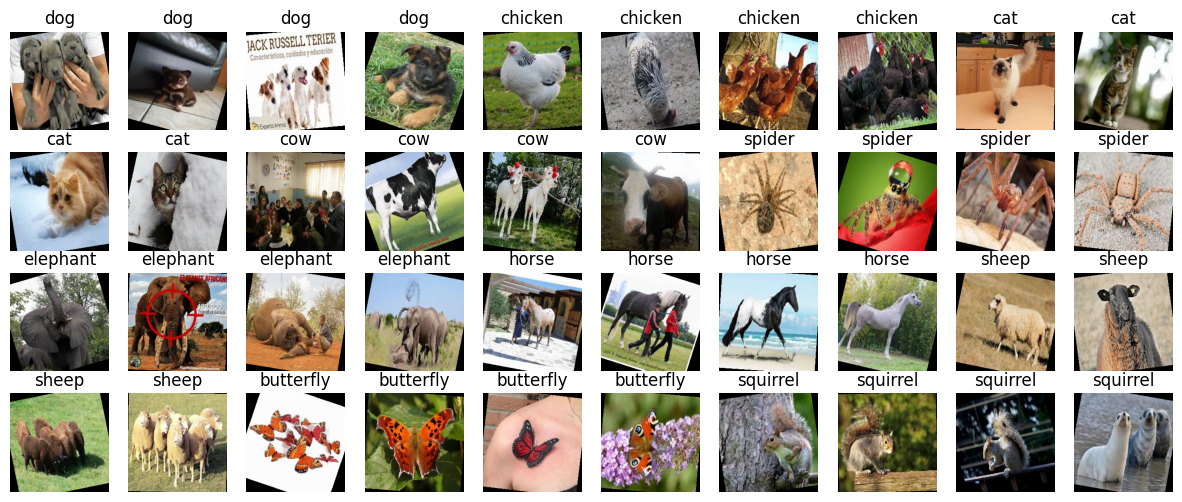

In [ ]:
visualize_class_samples(train_dl, n=4)

### Validation dataset
Visualise 2 samples for each class for validation dataset. We see that the quality of data is good and we do not observe any noises.

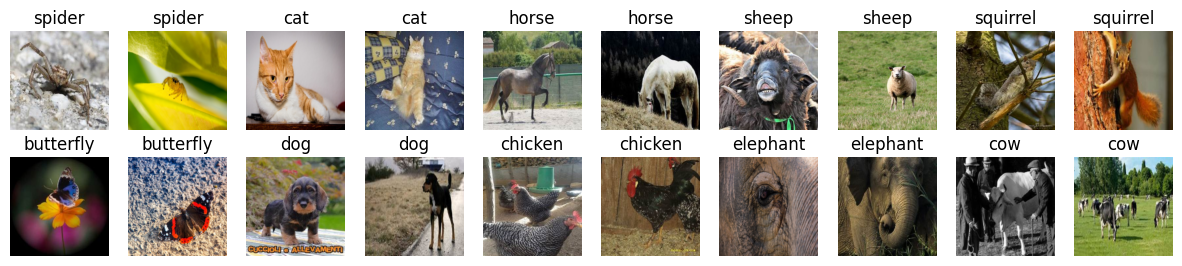

In [ ]:
visualize_class_samples(val_dl, n=2)

### Test dataset
Visualise 2 samples for each class for test dataset. We see that the quality of data is good and we do not observe any noises.

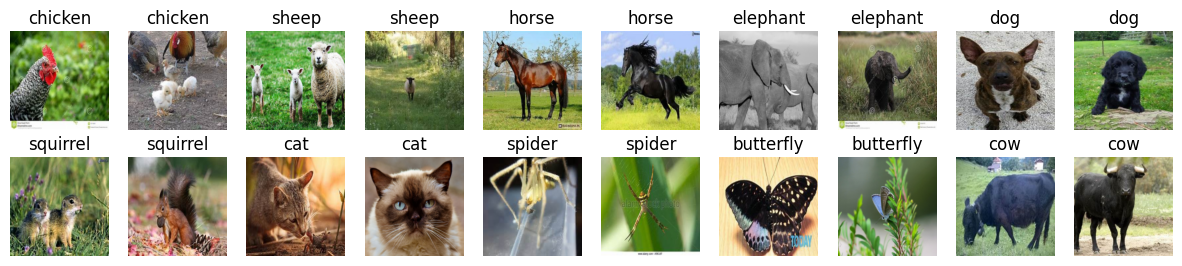

In [ ]:
visualize_class_samples(test_dl, n=2)

## Visualise count of pictures in each class

In [ ]:
def count_class_samples(dataset):
    """
    Count the number of samples in each class of the given dataset.

    Parameters:
    - dataset: A PyTorch dataset.

    Returns:
    - A dictionary with class names as keys and sample counts as values.
    """
    # Create a dictionary to hold the class counts
    class_count = defaultdict(int)

    # Iterate through the dataset to count classes
    for _, label in dataset:
        class_name = classes[label]  # Get class name using the label
        class_count[class_name] += 1  # Increment count for the specific class

    return dict(class_count)

In [ ]:
def hist_count_class_samples(class_count):
    """
    Visualizes the count of samples in each class using a bar chart.

    Parameters:
    - class_count: A dictionary with class names as keys and sample counts as values.
    """
    plt.figure(figsize=(10, 5))
    plt.bar(class_count.keys(), class_count.values(), color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images per Class')
    plt.title('Number of Images per Class in the Dataset')
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
def pie_count_class_samples(class_count):
    """
    Visualizes the count of samples in each class using a pie chart.

    Parameters:
    - class_count: A dictionary with class names as keys and sample counts as values.
    """
    # Extract class names and counts
    classes = list(class_count.keys())
    counts = list(class_count.values())

    # Create a pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=classes, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
    plt.title('Distribution of Samples per Class in the Dataset')
    plt.show()

### Original dataset
**The original dataset is unbalanced**. There are the most images of dogs and spiders (around 4800 for both classes). Next two "popular" classes are chicken (3098 images) and horse (2623). For other classes number of pictures varies between 1446 to 2112 images.

In [ ]:
full_data_class_count = count_class_samples(data)
full_data_class_count

{'dog': 4863,
 'horse': 2623,
 'elephant': 1446,
 'butterfly': 2112,
 'chicken': 3098,
 'cat': 1668,
 'cow': 1866,
 'sheep': 1820,
 'spider': 4821,
 'squirrel': 1862}

Similar situation as or original dataset is observed for train, validation and test subsets. They are unbalanced and the proportion of classes is analogical.

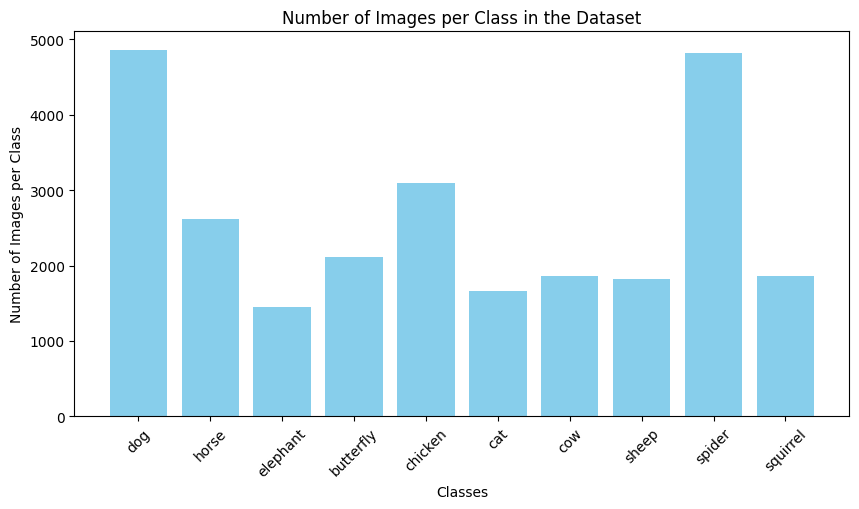

In [ ]:
hist_count_class_samples(full_data_class_count)

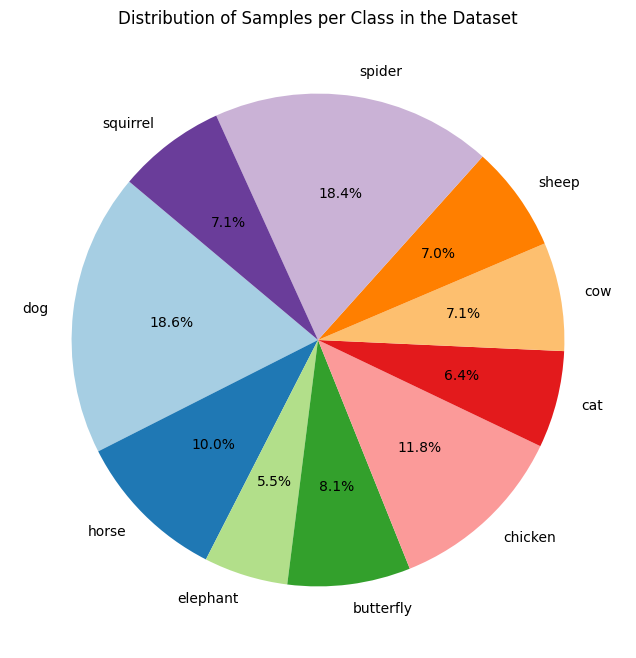

In [ ]:
pie_count_class_samples(full_data_class_count)

### Train dataset

In [ ]:
train_class_count = count_class_samples(train_ds)
train_class_count

{'sheep': 1225,
 'elephant': 911,
 'cow': 1227,
 'chicken': 2023,
 'cat': 1073,
 'spider': 3141,
 'horse': 1688,
 'dog': 3197,
 'butterfly': 1318,
 'squirrel': 1214}

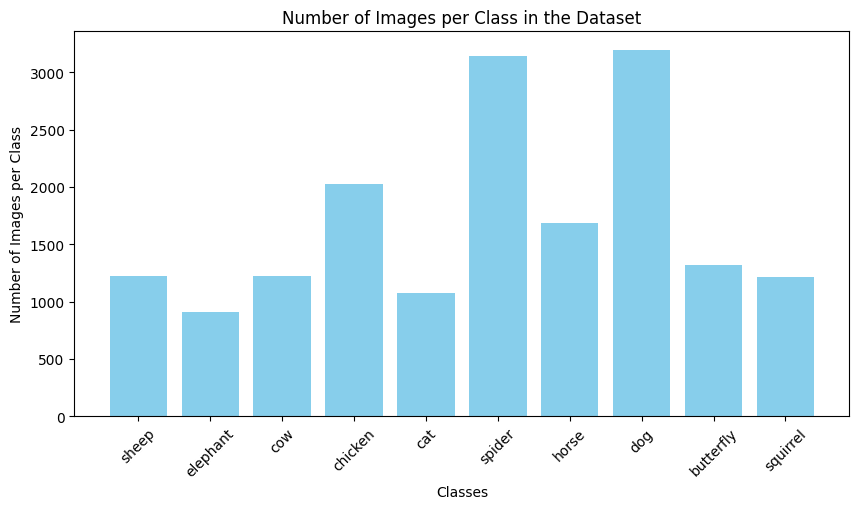

In [ ]:
hist_count_class_samples(train_class_count)

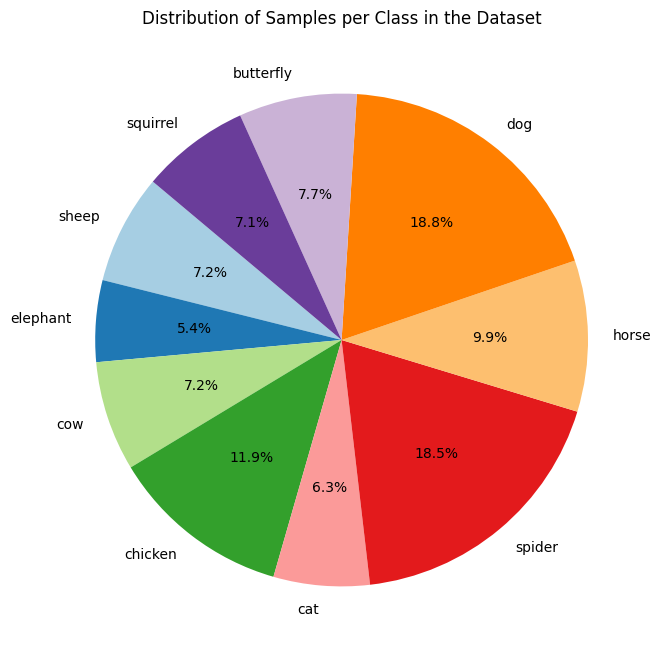

In [ ]:
pie_count_class_samples(train_class_count)

### Validation dataset

In [ ]:
val_class_count = count_class_samples(val_ds)
val_class_count

{'spider': 725,
 'cat': 246,
 'horse': 393,
 'sheep': 249,
 'squirrel': 279,
 'butterfly': 320,
 'dog': 701,
 'chicken': 480,
 'elephant': 244,
 'cow': 290}

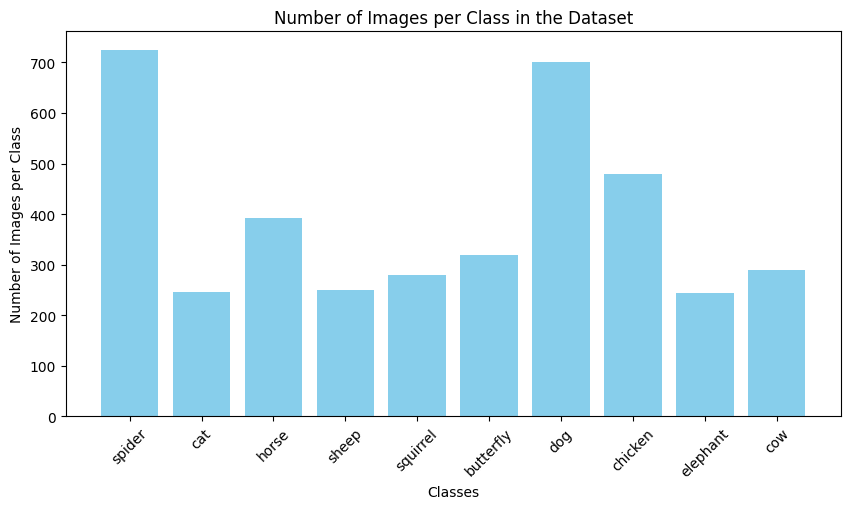

In [ ]:
hist_count_class_samples(val_class_count)

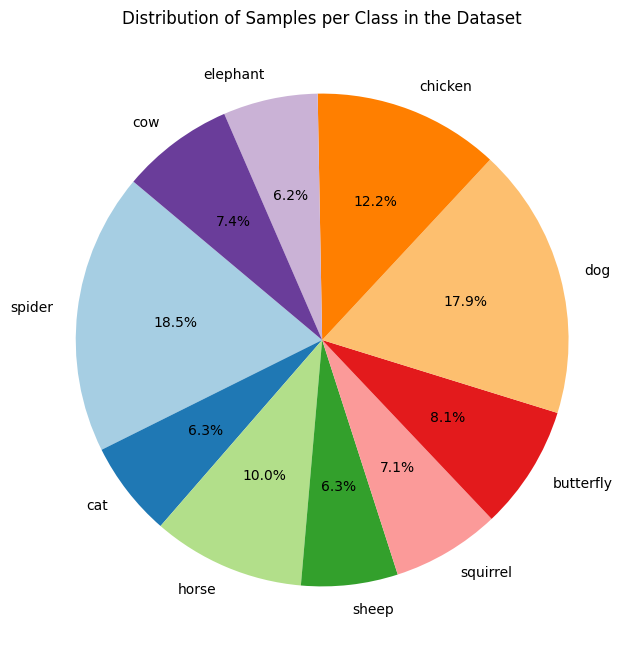

In [ ]:
pie_count_class_samples(val_class_count)

### Test dataset

In [ ]:
test_class_count = count_class_samples(test_ds)
test_class_count

{'chicken': 595,
 'sheep': 346,
 'horse': 542,
 'elephant': 291,
 'dog': 965,
 'squirrel': 369,
 'cat': 349,
 'spider': 955,
 'butterfly': 474,
 'cow': 349}

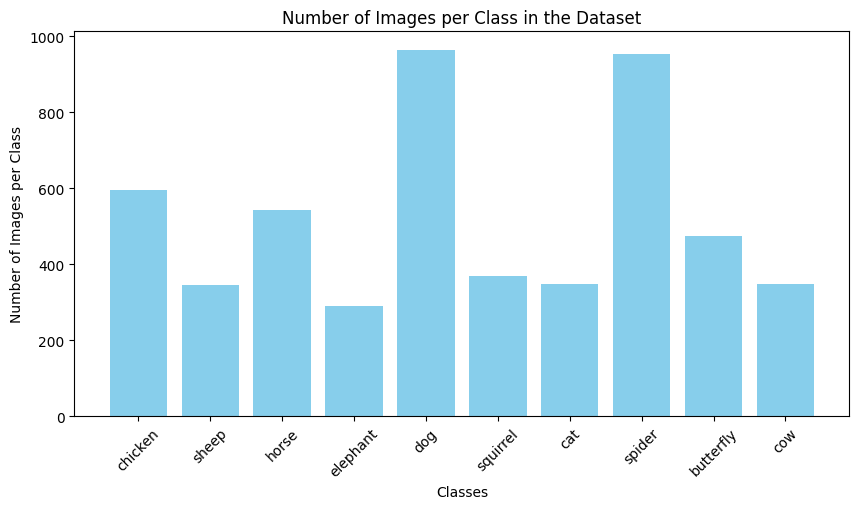

In [ ]:
hist_count_class_samples(test_class_count)

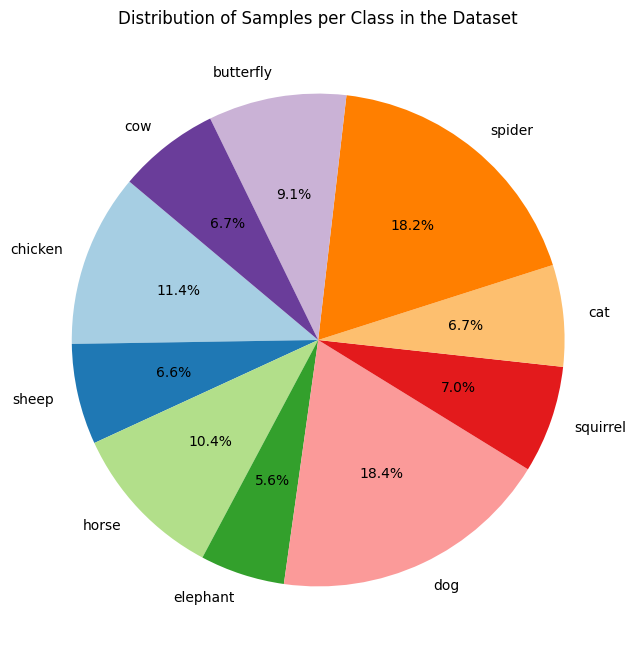

In [ ]:
pie_count_class_samples(test_class_count)